In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataset.zip

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
path_train_pneumonia =  '/content/train/PNEUMONIA'
path_train_normal = '/content/train/NORMAL'
path_test_normal = '/content/test/normal test'
path_test_pneumonia = '/content/test/pneumonia test'
path_val_normal =  '/content/val/normal val'
path_val_pneumonia = '/content/val/pneumonia val'

In [ ]:
path_train =  '/content/train'
path_test = '/content/test'
path_val= '/content/val'

In [ ]:
from glob import glob
images_path = glob(path_train_normal+"/*.jpeg")
images = []
for  path in images_path:
     images.append((path,0))
Pneumonia_images_path =  glob(path_train_pneumonia+"/*.jpeg")
for path in Pneumonia_images_path:
    images.append((path,1))

<Axes: ylabel='labels'>

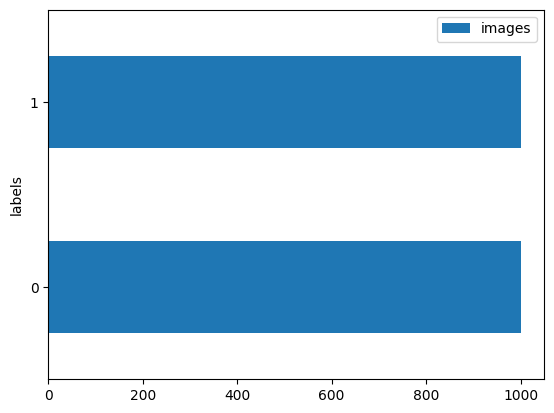

In [ ]:
df = pd.DataFrame(images, columns=['images','labels'])
df.groupby('labels').count().plot.barh()

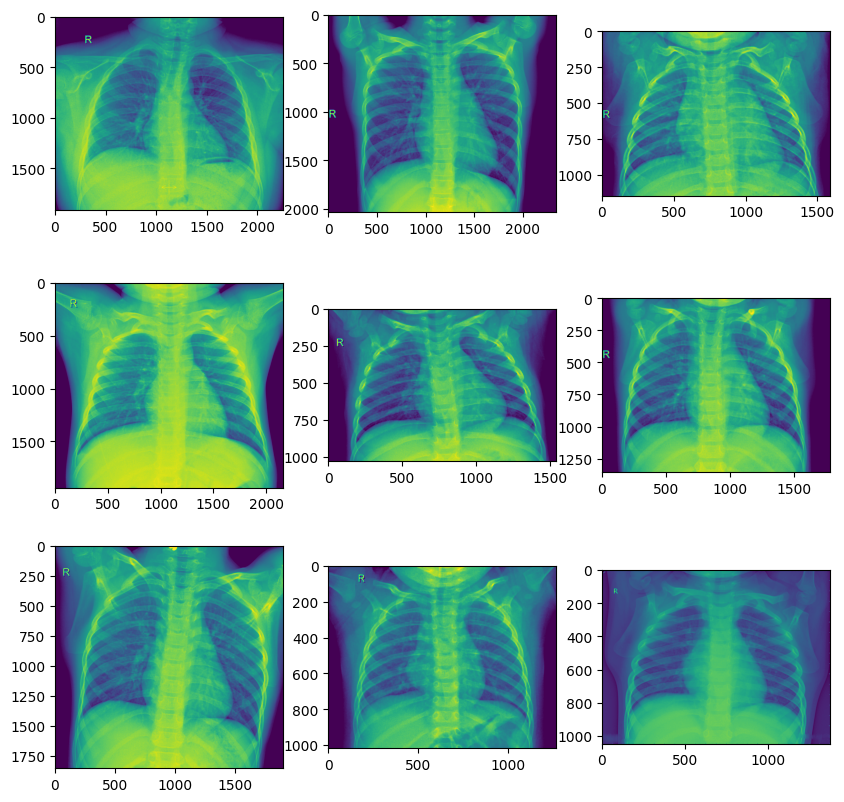

In [ ]:
plt.figure(figsize=(10,10))
im = []
for i in range(0,10):
    im.append(plt.imread(df.loc[i].images))
len(im)
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.imshow(im[i])

In [ ]:
IMG_SIZE = 150
BATCH_SIZE = 32

In [ ]:
img_generator =keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                            rotation_range=10,
                                                            shear_range=0.2,
                                                            zoom_range=0.2,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            horizontal_flip=True)



train_generator = img_generator.flow_from_directory(path_train,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  #color_mode="grayscale",
                                                  shuffle=True,
                                                  class_mode='binary',
                                                  subset='training')

val_generator  = img_generator.flow_from_directory(path_val,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  #batch_size= BATCH_SIZE,
                                                  #color_mode="grayscale",
                                                  shuffle=False,
                                                  class_mode='binary',
                                                  )

test_generator = img_generator.flow_from_directory(path_test,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  #color_mode="grayscale",
                                                  shuffle=False,
                                                  class_mode='binary')
plt.imshow(train_generator[0][0][0])

Found 2000 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
# CNN Model

In [ ]:
# sequential model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
# layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001) #0.00001 reduce the learning rate when the metrics isnt improoving
#early_stopping = EarlyStopping(patience = 5)
callback = [learning_rate_reduction]
cnn_model =  Sequential()

In [ ]:
cnn_model.add(Conv2D(32,(3,3), activation ='relu', input_shape=(IMG_SIZE , IMG_SIZE,3)))#Convlayer mit 32 Filtern der Größe 3x3.
cnn_model.add(Conv2D(64, (3,3),activation='relu')) #increase the non-linearity
cnn_model.add(MaxPooling2D(2,2)) #die features-Maps werden als 2x2 array transformiert
#cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(128, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Flatten())#Matrizendaten abflachen, weil die Fully-Connected layer die Daten als Vector nimmt.
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 64)        0         
 g2D)                                                   

In [ ]:
model = cnn_model.fit_generator(train_generator,
                                steps_per_epoch = 30,
                                epochs = 20,
                                validation_data=val_generator,
                                validation_steps=len(val_generator),
                                callbacks = callback)

<ipython-input-15-6ac22308cdef>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model = cnn_model.fit_generator(train_generator,


Epoch 1/20
30/30 [==============================] - 169s 6s/step - loss: 0.7200 - accuracy: 0.4969 - val_loss: 0.6937 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
30/30 [==============================] - 173s 6s/step - loss: 0.6201 - accuracy: 0.6515 - val_loss: 0.4504 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/20
30/30 [==============================] - 161s 5s/step - loss: 0.5838 - accuracy: 0.7365 - val_loss: 0.5203 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/20
30/30 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.7688
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
30/30 [==============================] - 159s 5s/step - loss: 0.4818 - accuracy: 0.7688 - val_loss: 0.4147 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/20
30/30 [==============================] - 155s 5s/step - loss: 0.3728 - accuracy: 0.8458 - val_loss: 0.6248 - val_accuracy: 0.8750 - lr: 5.0000e-04
Epoch 6/20
30/30 [==============================] - ETA: 0s - loss:

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history['val_accuracy'],label='validation Accuracy')
plt.plot(model.history['accuracy'], label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training  Accuracy')

plt.subplot(1, 2, 2)
plt.plot(model.history['val_loss'],label='validation loss')
plt.plot(model.history['loss'], label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training  Loss')

plt.show()

In [ ]:
predic= cnn_model.evaluate(test_generator)
predictions =  cnn_model.predict_generator(test_generator)

4/4 [==============================] - 5s 945ms/step - loss: 0.6389 - accuracy: 0.7200


<ipython-input-17-ecad7d374105>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions =  cnn_model.predict_generator(test_generator)


In [ ]:
CNN_prediction_final = np.where(predictions>0.5,1,0)
print(classification_report(test_generator.classes,CNN_prediction_final , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.74      0.50      0.60        50
   Normal (Class 0)       0.62      0.82      0.71        50

           accuracy                           0.66       100
          macro avg       0.68      0.66      0.65       100
       weighted avg       0.68      0.66      0.65       100



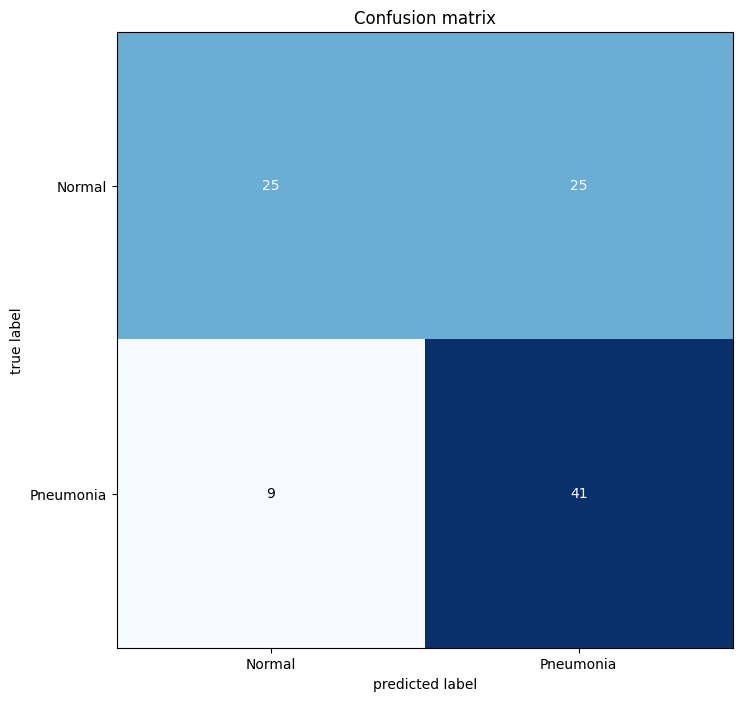

In [ ]:
CM = confusion_matrix(test_generator.classes, CNN_prediction_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( test_generator.classes , predictions)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

AUC Score: 0.7916


In [ ]:
# Extracting features

In [ ]:
model_feat = tf.keras.Model(inputs=cnn_model.input,outputs=cnn_model.get_layer('dense_1').output)
feat_train = model_feat.predict_generator(train_generator)
feat_test = model_feat.predict_generator(test_generator)

<ipython-input-22-3ed6e61f40f2>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  feat_train = model_feat.predict_generator(train_generator)
<ipython-input-22-3ed6e61f40f2>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  feat_test = model_feat.predict_generator(test_generator)


In [ ]:
df = pd.DataFrame(feat_train)
df.shape

(2000, 1)

In [ ]:
#   SVM

In [ ]:
from sklearn.svm import SVC
from sklearn import metrics
svm = SVC(kernel='sigmoid')
svm.fit(feat_train,train_generator.classes)
svmpredict = svm.predict(feat_test)
print(classification_report(test_generator.classes,svmpredict , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.26      0.14      0.18        50
   Normal (Class 0)       0.41      0.60      0.49        50

           accuracy                           0.37       100
          macro avg       0.34      0.37      0.33       100
       weighted avg       0.34      0.37      0.33       100



AUC Score: 0.37


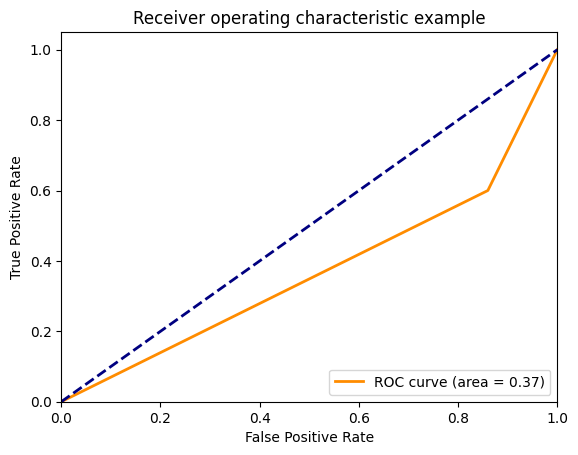

In [ ]:
fpr , tpr , thresholds = roc_curve ( test_generator.classes ,svmpredict)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

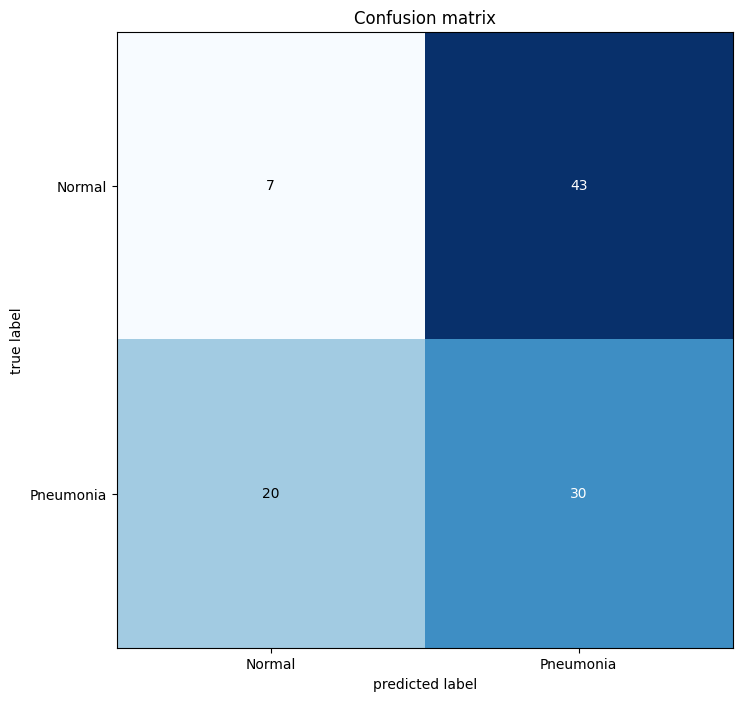

In [ ]:
svmCM = confusion_matrix(test_generator.classes, svmpredict)

fig, ax = plot_confusion_matrix(conf_mat=svmCM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

In [ ]:
# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(feat_train,train_generator.classes)

knnpredict = knn.predict(feat_test)
print(classification_report(test_generator.classes,knnpredict , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))
knn.score(feat_test,test_generator.classes)

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.54      0.82      0.65        50
   Normal (Class 0)       0.62      0.30      0.41        50

           accuracy                           0.56       100
          macro avg       0.58      0.56      0.53       100
       weighted avg       0.58      0.56      0.53       100



0.56

AUC Score: 0.56


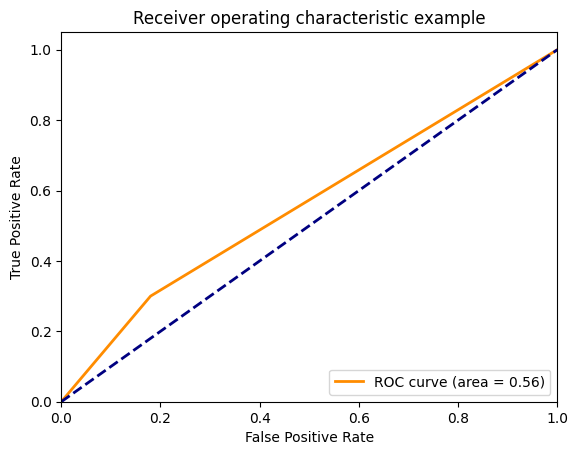

In [ ]:
fpr , tpr , thresholds = roc_curve ( test_generator.classes ,knnpredict)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

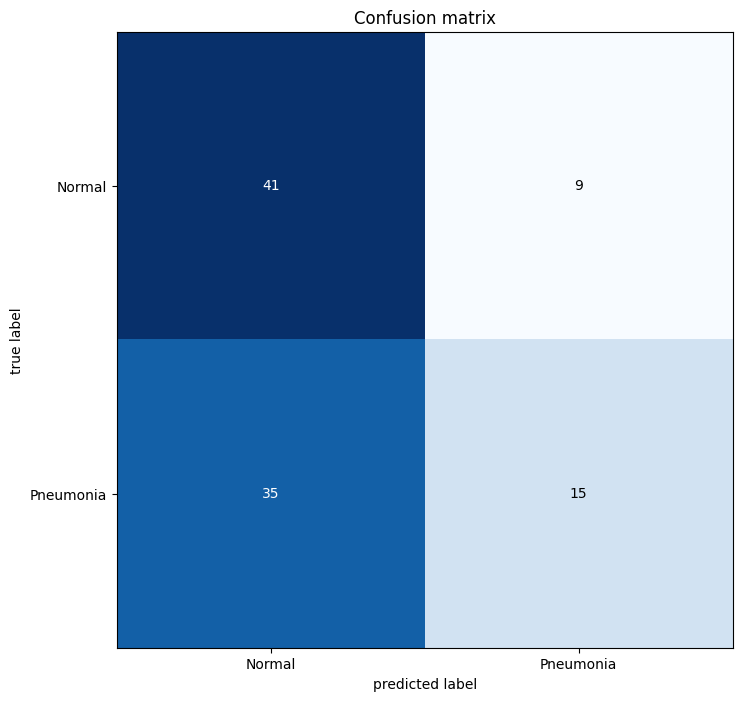

In [ ]:
knnCM = confusion_matrix(test_generator.classes, knnpredict)

fig, ax = plot_confusion_matrix(conf_mat=knnCM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

In [ ]:
# DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(feat_train,train_generator.classes)

dtpredict = dt.predict(feat_test)
print(classification_report(test_generator.classes,dtpredict , target_names = ['Pneumonia (Class 1)','Normal (Class 0)']))

                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.58      0.60      0.59        50
   Normal (Class 0)       0.58      0.56      0.57        50

           accuracy                           0.58       100
          macro avg       0.58      0.58      0.58       100
       weighted avg       0.58      0.58      0.58       100



AUC Score: 0.58


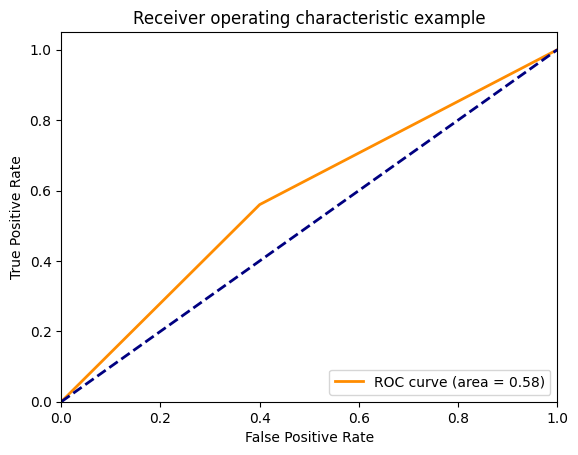

In [ ]:
fpr , tpr , thresholds = roc_curve ( test_generator.classes ,dtpredict)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_classifier.fit(feat_train, train_generator.classes)

# Make predictions on the test data
rf_predictions = rf_classifier.predict(feat_test)

# Print the classification report
print(classification_report(test_generator.classes, rf_predictions, target_names=['Pneumonia (Class 1)', 'Normal (Class 0)']))


                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.58      0.60      0.59        50
   Normal (Class 0)       0.58      0.56      0.57        50

           accuracy                           0.58       100
          macro avg       0.58      0.58      0.58       100
       weighted avg       0.58      0.58      0.58       100



AUC Score: 0.58


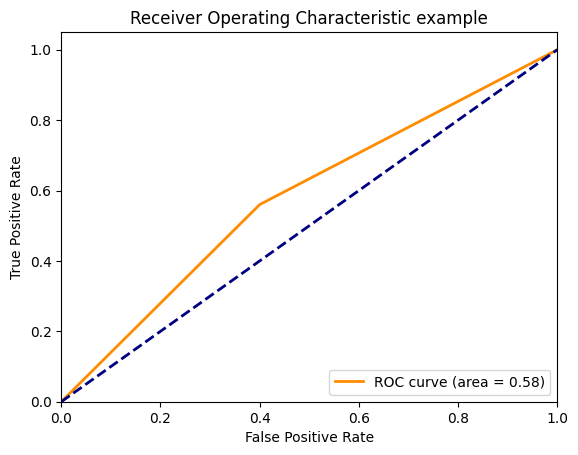

In [ ]:

fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_generator.classes, rf_predictions)
auc_rf = auc(fpr_rf, tpr_rf)

print("AUC Score:", auc_rf)

plt.figure()
lw = 2
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# BAGGING CLASSIFIER and ADABOOST CLASSIFIER

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Classifier:
                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.26      0.14      0.18        50
   Normal (Class 0)       0.41      0.60      0.49        50

           accuracy                           0.37       100
          macro avg       0.34      0.37      0.33       100
       weighted avg       0.34      0.37      0.33       100



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost Classifier:
                     precision    recall  f1-score   support

Pneumonia (Class 1)       0.58      0.60      0.59        50
   Normal (Class 0)       0.58      0.56      0.57        50

           accuracy                           0.58       100
          macro avg       0.58      0.58      0.58       100
       weighted avg       0.58      0.58      0.58       100



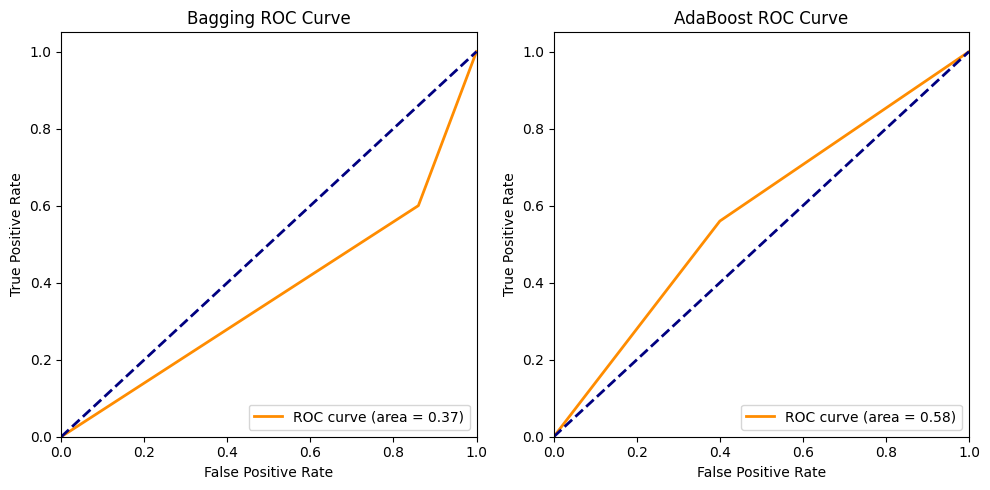

In [ ]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Bagging Classifier
bagging_classifier = BaggingClassifier(base_estimator=SVC(kernel='sigmoid'), n_estimators=10, random_state=42)
bagging_classifier.fit(feat_train, train_generator.classes)
bagging_predictions = bagging_classifier.predict(feat_test)

# Printing Classification Report for Bagging
print("Bagging Classifier:")
print(classification_report(test_generator.classes, bagging_predictions, target_names=['Pneumonia (Class 1)', 'Normal (Class 0)']))

# AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm='SAMME', n_estimators=50, random_state=42)

adaboost_classifier.fit(feat_train, train_generator.classes)
adaboost_predictions = adaboost_classifier.predict(feat_test)

# Printing Classification Report for AdaBoost
print("AdaBoost Classifier:")
print(classification_report(test_generator.classes, adaboost_predictions, target_names=['Pneumonia (Class 1)', 'Normal (Class 0)']))

# Plotting ROC curves for Bagging and AdaBoost
plt.figure(figsize=(10, 5))

# Bagging
fpr_bagging, tpr_bagging, thresholds_bagging = roc_curve(test_generator.classes, bagging_predictions)
auc_bagging = auc(fpr_bagging, tpr_bagging)
plt.subplot(1, 2, 1)
plt.plot(fpr_bagging, tpr_bagging, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_bagging)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging ROC Curve')
plt.legend(loc="lower right")

# AdaBoost
fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(test_generator.classes, adaboost_predictions)
auc_adaboost = auc(fpr_adaboost, tpr_adaboost)
plt.subplot(1, 2, 2)
plt.plot(fpr_adaboost, tpr_adaboost, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_adaboost)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [ ]:
# Evaluating various classifiers :-

In [ ]:
pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming feat_train, train_generator.classes, feat_test, test_generator.classes are already defined

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feat_train, train_generator.classes, test_size=0.2, random_state=42)

# Use LazyClassifier for a quick model comparison
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the model performance summaries
print(models)





100%|██████████| 29/29 [00:02<00:00, 13.90it/s]

[LightGBM] [Info] Number of positive: 799, number of negative: 801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499375 -> initscore=-0.002500
[LightGBM] [Info] Start training from score -0.002500
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.54               0.53     0.53      0.53   
RandomForestClassifier             0.53               0.53     0.53      0.53   
DecisionTreeClassifier             0.53               0.53     0.53      0.53   
ExtraTreeClassifier                0.53               0.52     0.52      0.52   
BaggingClassifier          